# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** [Input Nama]
- **Email:** [Input Email]
- **ID Dicoding:** [Input Username]

## Import Semua Packages/Library yang Digunakan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, random_shear, random_zoom

from sklearn.model_selection import train_test_split
from skimage import io, img_as_ubyte

from PIL import Image

import cv2
import os
import shutil
import time
import warnings

warnings.filterwarnings("ignore")


In [5]:
!python --version

Python 3.10.15


## Data Preparation

### Data Loading

In [6]:
# define the base of input and output directory
# input: read-only directory, output: working directory
base_input = '/kaggle/input/sea-animals-image-dataste'
base_working = '/kaggle/working'

categories_path = [os.path.join(base_input, class_name) for class_name in os.listdir(base_input)]

In [4]:
# moving all images into working directory
start_time = time.time()
for num, path in enumerate(categories_path):
    # define destination for directories to be copied
    destination = os.path.join(base_working, 'datasets', path.split('/')[-1])
    
    # check if path is directory
    if os.path.isdir(path):
        # copy directories and sub-dir to destination
        shutil.copytree(path, destination, dirs_exist_ok=True)
        print(f"\r ({num+1}/{len(categories_path)}) {int(time.time() - start_time)}s Copied \33[32m{path}\33[0m to \33[35m{destination}\33[0m", end=" ")

 (23/23) 136s Copied /kaggle/input/sea-animals-image-dataste/Jelly Fish to /kaggle/working/datasets/Jelly Fish toise 

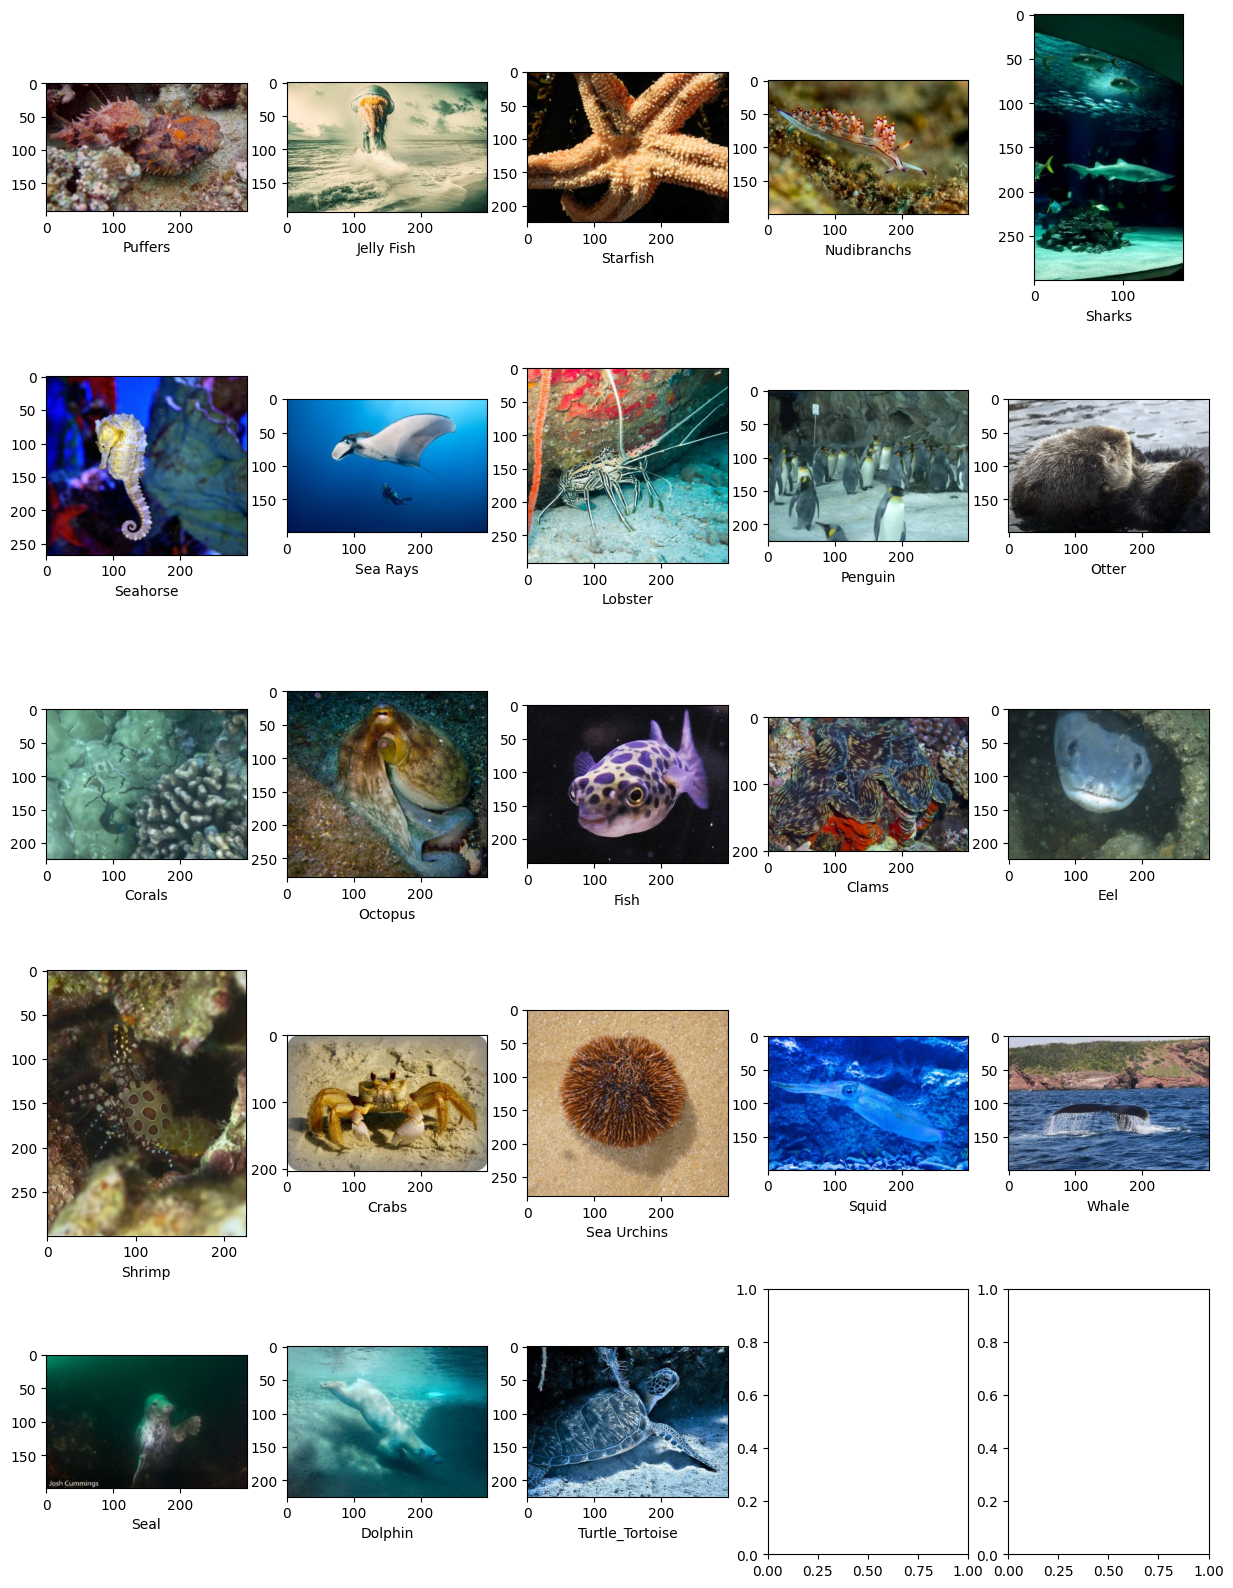

In [5]:
datasets_dir = base_working + "/datasets"
# redifine categories path in working directories
categories_path = [os.path.join(datasets_dir, class_name) for class_name in os.listdir(datasets_dir)]

# visualize random images from each categories
ncols = 5
nrows = (len(os.listdir(datasets_dir)) // 5) + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axs = axs.flatten()

i = 0
for category_path in categories_path:
    rand_img = np.random.choice(os.listdir(category_path))
    img = Image.open(os.path.join(category_path, rand_img)).convert('RGBA')
    axs[i].imshow(img)
    axs[i].set_xlabel(category_path.split('/')[-1])
    i += 1


In [6]:
file_paths = []
file_names = []
labels = []

for path in categories_path:
    for filename in os.listdir(path):
        file_names.append(filename)
        labels.append(path.split('/')[-1])
        file_paths.append(os.path.join(path, filename))

df = pd.DataFrame({'filepath' : file_paths, 'filename' : file_names, 'label' : labels})
print(f"Number of labels: {len(df['label'].unique())}")
print(f"Number of images: {len(df)}")
df.head()

Number of labels: 23
Number of images: 13711


,filepath,filename,label
0,/kaggle/working/datasets/Puffers/5269093152_c7...,5269093152_c72b0c479c_b.jpg,Puffers
1,/kaggle/working/datasets/Puffers/5324286082_fc...,5324286082_fcbfc3b530_o.jpg,Puffers
2,/kaggle/working/datasets/Puffers/6974451463_af...,6974451463_af37ca1cdf_o.jpg,Puffers
3,/kaggle/working/datasets/Puffers/25403548374_d...,25403548374_dcdf038d39_o.jpg,Puffers
4,/kaggle/working/datasets/Puffers/5267462855_1f...,5267462855_1f508a14a9_b.jpg,Puffers


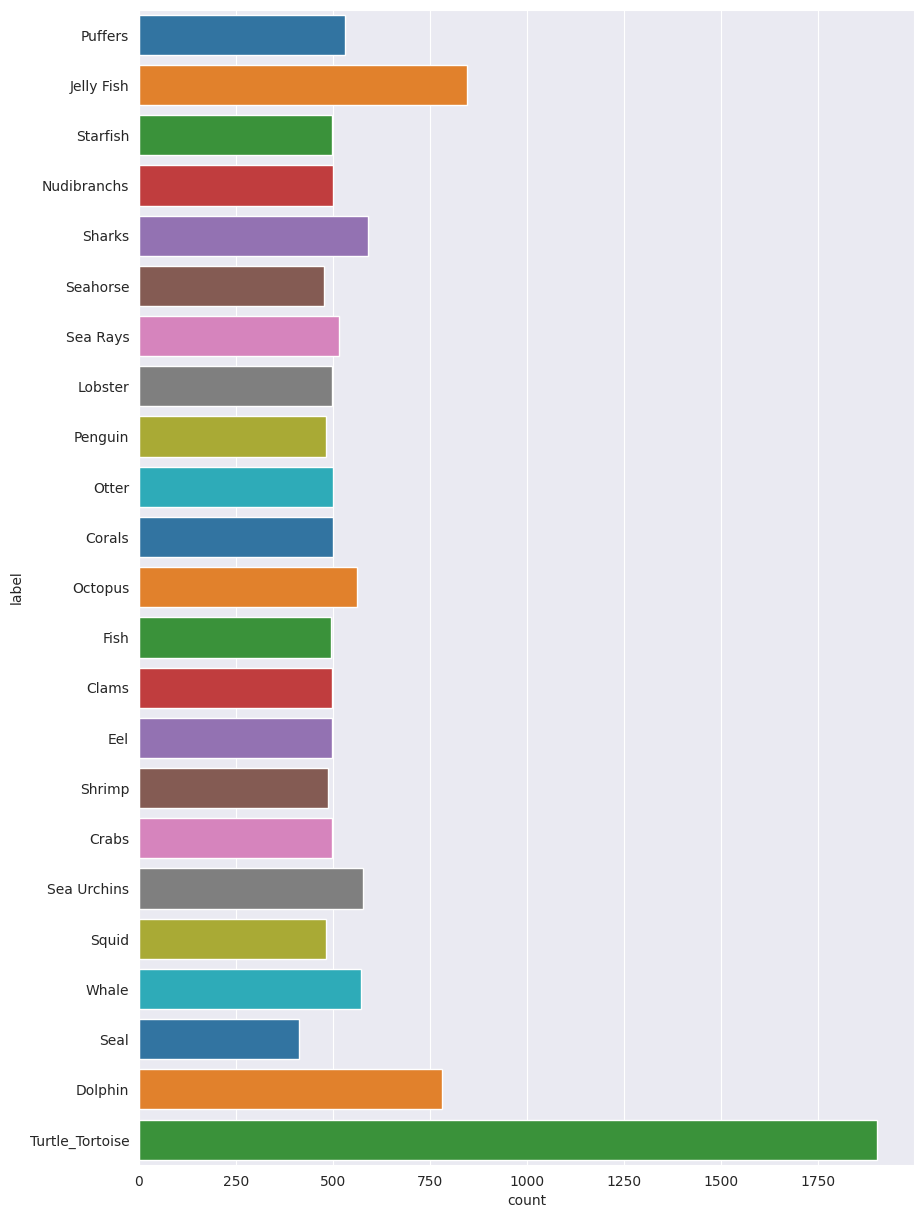

In [7]:
def plot_distribution(df, labels, palette=sns.color_palette()):
    plt.figure(figsize=(10,15))
    sns.set_style('darkgrid')
    sns.countplot(data=df, y=labels, hue_order=labels, palette=palette)

plot_distribution(df, 'label')

### Data Preprocessing

#### Split Dataset

In [8]:
df.sample(5)

,filepath,filename,label
745,/kaggle/working/datasets/Jelly Fish/3895900290...,38959002900_b533e4b2cd_o.jpg,Jelly Fish
57,/kaggle/working/datasets/Puffers/3094107611_5f...,3094107611_5fc5178cd0_o.jpg,Puffers
7972,/kaggle/working/datasets/Eel/14014665812_ac1d3...,14014665812_ac1d332d1e_o.jpg,Eel
10653,/kaggle/working/datasets/Seal/6016848411_7fbf3...,6016848411_7fbf390e4a_o.jpg,Seal
1715,/kaggle/working/datasets/Starfish/5021013512_a...,5021013512_a50febbabc_o.jpg,Starfish


In [9]:
X = df['filepath']
y = df['label']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

print(f"Train set portion: {X_train.shape[0]}")
print(f"Test set portion: {X_test.shape[0]}")

Train set portion: 10968
Test set portion: 2743


In [10]:
df_train = pd.DataFrame({'file_path': X_train, 'label': y_train, 'set':'train'})
df_test = pd.DataFrame({'file_path': X_test, 'label': y_test, 'set':'test'})
df_split = pd.concat([df_train, df_test])
df_split.sample(10)

,file_path,label,set
8661,/kaggle/working/datasets/Crabs/3027943245_e63c...,Crabs,train
6812,/kaggle/working/datasets/Fish/16010919710_4efb...,Fish,train
6439,/kaggle/working/datasets/Octopus/6804882782_88...,Octopus,train
13489,/kaggle/working/datasets/Turtle_Tortoise/Turtl...,Turtle_Tortoise,train
13188,/kaggle/working/datasets/Turtle_Tortoise/Turtl...,Turtle_Tortoise,train
12575,/kaggle/working/datasets/Turtle_Tortoise/Turtl...,Turtle_Tortoise,train
9982,/kaggle/working/datasets/Squid/491055561_278f6...,Squid,train
1374,/kaggle/working/datasets/Jelly Fish/4045256866...,Jelly Fish,train
445,/kaggle/working/datasets/Puffers/6187889341_e5...,Puffers,test
5837,/kaggle/working/datasets/Corals/7217730710_3cd...,Corals,test


<Axes: xlabel='set', ylabel='count'>

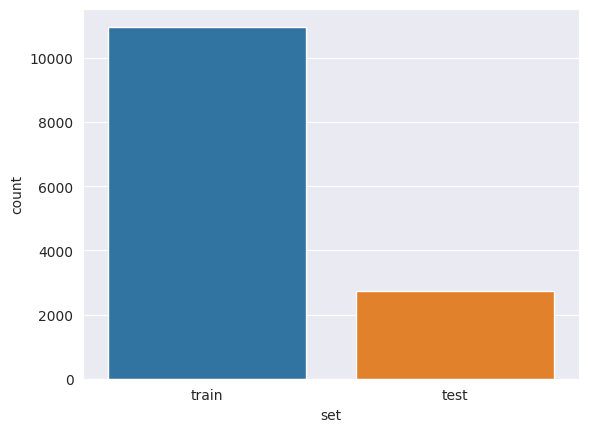

In [11]:
sns.countplot(df_split, x=df_split['set'])

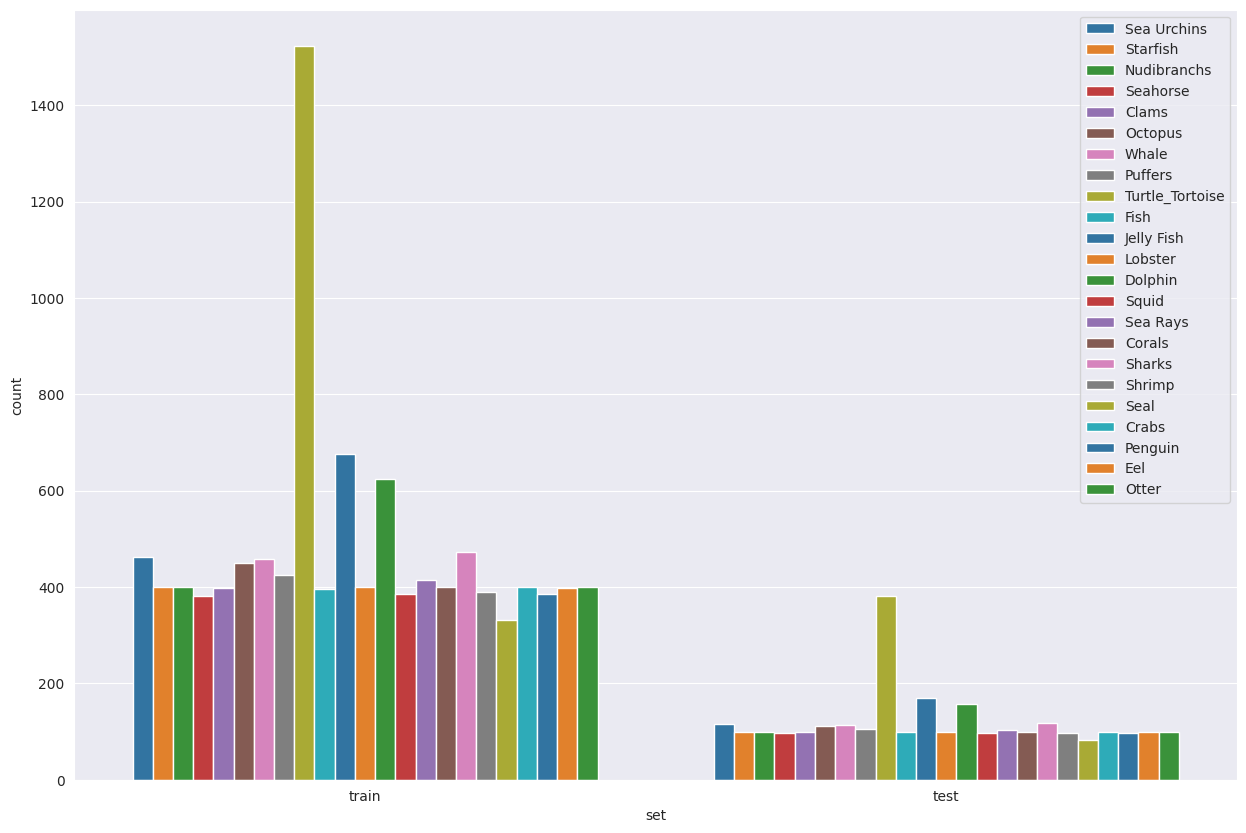

In [12]:
plt.figure(figsize=(15,10))
sns.countplot(df_split, x='set', hue='label', palette=sns.color_palette())
plt.legend(loc=1)

In [13]:
train_zip = zip(df_train['file_path'], df_train['set'])
test_zip = zip(df_test['file_path'], df_test['set'])

start_time = time.time()
current_set = None

for path, set in [*train_zip, *test_zip]:
    if current_set != set:  # Check if the 'set' value has changed
        print()
        current_set = set
        num = 0  # Reset the counter
        start_time = time.time()  # Reset the timer
        
    source = '/'.join(path.split('/')[:-1])
    
    # define destination path=/kaggle/working/{set}/{category}
    destination = os.path.join(base_working, set, path.split('/')[-2])
    if os.path.isdir(source):
        # copy dir and subdir to destination directory
        shutil.copytree(source, destination, dirs_exist_ok=True)
        
        # verbose
        if set == 'train':
            print(f"\r{set}-({num+1}/{len(df_train)}) {int(time.time() - start_time)}s Copied \33[32m{source}\33[0m to \33[35m{destination}\33[0m", end=" ")
        else:
            print(f"\r{set}-({num+1}/{len(df_test)}) {int(time.time() - start_time)}s Copied \33[32m{source}\33[0m to \33[35m{destination}\33[0m", end=" ")
        num += 1


train-(10968/10968) 1605s Copied /kaggle/working/datasets/Crabs to /kaggle/working/train/Crabs  Fish toise 
test-(2743/2743) 391s Copied /kaggle/working/datasets/Puffers to /kaggle/working/test/Puffers ins ise 

## **Generate a new images through the transformations**

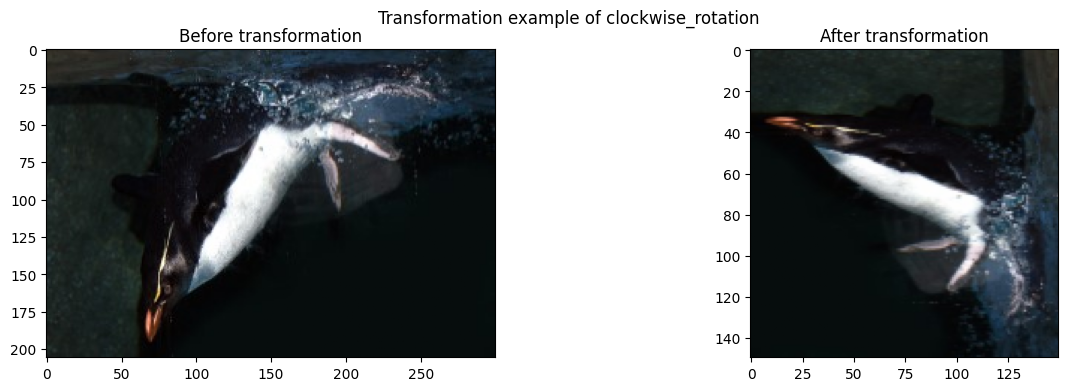

In [5]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
# define resize shape
resize_shape = (150, 150)

# clockwise rotation augmentation
def clockwise_rotation(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return img

# flip the image up and down
def flip_up_down(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.flip_up_down(img)
    return img

# flip the iamge left and right
def flip_left_right(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.flip_left_right(img)
    return img

# add the image brightness
def add_brightness(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    return img

# Share the iamge randomly
def sheared(img):
    img = tf.image.resize(img, resize_shape)
    img = random_shear(img, intensity=0.2)
    return img

# zoom the image
def zoomed(img):
    img = tf.image.resize(img, resize_shape)
    img = random_zoom(img, zoom_range=[0, 2], row_axis=0, col_axis=1, channel_axis=2)
    return img


# Plot the transformation
def plot_transformation(img, transformation):
    key = transformation
    # read the image file
    image = io.imread(image_path)

    # convert an image into tensor and normalize
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0

    # apply transformation of the image
    img_transformed = transformations[key](image)

    # plot the original and transformed image
    fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
    fig.suptitle(f"Transformation example of {transformation}")
    ax[0].imshow(image)
    ax[0].set_title('Before transformation')
    ax[1].imshow(img_transformed)
    ax[1].set_title('After transformation')


# Define all transformation in variable
transformations = {
    'clockwise_rotation' : clockwise_rotation,
    'flip_up_down' : flip_up_down,
    'flip_left_right' : flip_left_right,
    'add_brightness' : add_brightness,
    'sheared' : sheared,
    'zoomed' : zoomed,
}
    
# Load image
image_path = categories_path[0] + '/' + os.listdir(categories_path[0])[0]
plot_transformation(image_path, transformation='clockwise_rotation')

In [15]:
TRAIN_DIR = os.path.join(base_working, 'train')
TEST_DIR = os.path.join(base_working, 'test')

In [ ]:
# Apply augmentation for all image to be same distribution to Turtle_tortoise
# Paths that would be generated
cat_tr_path = [os.path.join(TRAIN_DIR, im) for im in os.listdir(TRAIN_DIR)]
paths_to_generate = [path for path in cat_tr_path if path.split('/')[-1] != 'Turtle_Tortoise']

start_time = time.time()
# iterate through the category paths
for num, path in enumerate(paths_to_generate):
    image_to_generate = 2000 # number of image to generate
    
    # images to be choosen randomly for transformation
    images_path = [os.path.join(path, im) for im in os.listdir(path)]
    
    
    i = 0 # for iteration count, how many times the image should be transformed 
    while i < image_to_generate:
        try:
            # randomly choose original image from current category
            original_image_path = random.choice(images_path)
            
            # read the image
            original_image = io.imread(original_image_path)
    
            # convert an image into tensor and normalize
            original_image = tf.convert_to_tensor(original_image, dtype=tf.float32) / 255.0
    
            # for transformed image
            image_transformed = None
            key = None
            # randomly choose number of transformation count
            transformed_count = random.randint(1, len(transformations))
            
            n = 0
            while n < transformed_count:
                # randomly select transformation type
                key = random.choice(list(transformations.keys()))
                
                # transform image
                image_transformed = transformations[key](original_image)
                
                n += 1
    
            # create a new path for saving a new transformed image
            image_transformed_path = f"{TRAIN_DIR}/{path.split('/')[-1]}/augmented_{original_image_path.split('/')[-1]}"
            
            # Normalize image to [0, 1] if pixel values are [0, 255]
            if image_transformed.dtype == np.float32 or image_transformed.dtype == np.float64:
                image_transformed = (image_transformed - np.min(image_transformed)) / (np.max(image_transformed) - np.min(image_transformed))
            
            # Convert to uint8
            image_transformed = img_as_ubyte(image_transformed)
            
            # store transformed image in file
            cv2.imwrite(image_transformed_path, image_transformed)
            
            i += 1
            print(f"\r({num}/{len(paths_to_generate)}) {int(time.time() - start_time)}s Generate image [{path.split('/')[-1]}] ({i}/{image_to_generate}) : \33[32m{original_image_path}\33[0m [ \33[33m{key}\33[0m ] => saved as \33[31m {image_transformed_path} \33[0m", end=" ")

        except ValueError as e:
            pass
        

(2/22) 283s Generate image [Starfish] (1386/2000) : /kaggle/working/train/Starfish/5648117438_95380edf6a_b.jpg [ sheared ] => saved as  /kaggle/working/train/Starfish/augmented_5648117438_95380edf6a_b.jpg      0m m g  

In [ ]:
OUTPUT_NAME = base_working + '/sea-animals_images'
shutil.make_archive(OUTPUT_NAME, 'zip', base_working)

from IPython.display import FileLink

# Path to the ZIP file
archived_file = '/kaggle/working/sea-animals_images.zip'

# Provide a direct download link
print(f"Click the link below to download the file:")
download_link = FileLink(archived_file)

!wget -O sea-animals_images.zip download_link

In [ ]:
df_split.sample(5)

In [ ]:
new_file_paths = []
new_labels = []

for cat_path in paths_to_generate:
    generated_files = [image for image in os.listdir(cat_path) if 'augmented' in image]
    for f in generated_files:
        new_file_paths.append(os.path.join(cat_path, f))
        new_labels.append(cat_path.split('/')[-1])

df_generated_images = pd.DataFrame({'file_path' : new_file_paths, 'label' : new_labels, 'set': 'train'})
df_generated_images.sample(5)

df_all = pd.concat([df_split, df_generated_images])
df_all.sample(5)

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(df_all, x='set', hue='label', palette=sns.color_palette())
plt.legend(loc=1)

In [45]:
TRAIN_DIR = '/kaggle/input/prepared-training-images/sea-animals_images/train'
TEST_DIR = '/kaggle/input/prepared-training-images/sea-animals_images/train'

RESIZE_SHAPE = (224, 224)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   validation_split=0.1)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=RESIZE_SHAPE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=True,
    subset='training',
)

valid_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=RESIZE_SHAPE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False,
    subset='validation',
)

test_generator = train_datagen.flow_from_directory(
    TEST_DIR,
    target_size=RESIZE_SHAPE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1,
    shuffle=False,
)

Found 22650 images belonging to 23 classes.
Found 2508 images belonging to 23 classes.
Found 25158 images belonging to 23 classes.


## Modelling

In [46]:
from tensorflow.keras.applications import MobileNet, ResNet50V2

base_model = ResNet50V2(
    input_shape=(224, 224, 3),
    weights="imagenet",
    include_top=False,
)

base_model.trainable = False

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-10:]:  # Adjust the number of layers to unfreeze
    layer.trainable = True

model = Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.5)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(23, activation='softmax')
])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 16)       │       819,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 7, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 23)             │         1,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,386,919 (93.03 MB)

 Trainable params: 4,238,023 (16.17 MB)

 Non-trainable params: 20,148,896 (76.86 MB)

In [47]:
from tensorflow.keras.callbacks import Callback
from datetime import datetime

curr_time = datetime.now()
v_format = curr_time.date().strftime("%d") +'_'+ curr_time.time().strftime("%H")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=base_working + "/ckpt/model_{epoch:02d}_{accuracy:.2f}_{val_accuracy:.2f}_v"+ v_format + ".keras",
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)


class EarlyStoppingOnTarget(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        # Ensure metrics are not None before comparison
        if acc is not None and val_acc is not None:
            if acc >= 96 and val_acc >= 96:
                print(f"Stopping training: Reached accuracy {acc}% and validation accuracy {val_acc}%.")
                self.model.stop_training = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
history = model.fit(train_generator, epochs=50,
                    batch_size=BATCH_SIZE,
                    validation_data=valid_generator, 
                    callbacks=[model_checkpoint, EarlyStoppingOnTarget(), reduce_lr])

Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.2803 - loss: 40.4392
Epoch 1: val_accuracy improved from -inf to 0.50758, saving model to /kaggle/working/ckpt/model_01_0.38_0.51_v16_23.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 86s 205ms/step - accuracy: 0.2806 - loss: 40.3836 - val_accuracy: 0.5076 - val_loss: 3.3306 - learning_rate: 0.0010
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5777 - loss: 2.2345
Epoch 2: val_accuracy improved from 0.50758 to 0.75837, saving model to /kaggle/working/ckpt/model_02_0.59_0.76_v16_23.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 64s 176ms/step - accuracy: 0.5778 - loss: 2.2343 - val_accuracy: 0.7584 - val_loss: 1.7407 - learning_rate: 0.0010
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6766 - loss: 1.8353
Epoch 3: val_accuracy improved from 0.75837 to 0.77791, saving model to /kaggle/working/ckpt/model_03_0.68_0.78_v16_23.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 62s 171ms/step - accuracy: 0.6766 - loss: 1.8

## Evaluasi dan Visualisasi

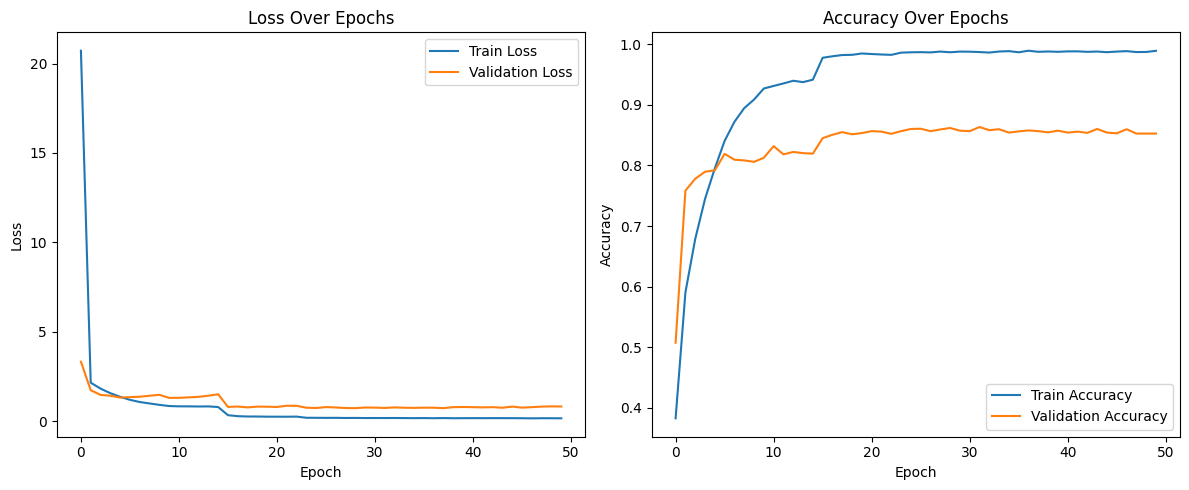

In [50]:
# Plot training train_history
plt.figure(figsize=(12, 5))
train_history = history.history
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_history["loss"], label="Train Loss")
plt.plot(train_history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_history["accuracy"], label="Train Accuracy")
plt.plot(train_history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [16]:
!pip install -q tensorflowjs


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import zipfile
def zip_folder(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            print(root)
            for file in files:
                print('--' + file)
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))
                
    print("Folder zipped successfully!")

In [13]:
load_model_path = '/kaggle/input/model_32_0.99_0.86_v16_23.keras/keras/default/1/model_32_0.99_0.86_v16_23.keras'
model_final = tf.keras.models.load_model(load_model_path)
model_final.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 16)       │       819,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 7, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 23)             │         1,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,862,967 (125.36 MB)

 Trainable params: 4,238,023 (16.17 MB)

 Non-trainable params: 20,148,896 (76.86 MB)

 Optimizer params: 8,476,048 (32.33 MB)

## SavedModel

In [14]:
savedmodel_path = '/kaggle/working/savedmodel'
tf.saved_model.save(model_final, savedmodel_path)

savedmodel_zip = f'{base_working}/savedmodel.zip'
zip_folder(savedmodel_path, savedmodel_zip)

INFO:tensorflow:Assets written to: /kaggle/working/savedmodel/assets


INFO:tensorflow:Assets written to: /kaggle/working/savedmodel/assets


/kaggle/working/savedmodel
--fingerprint.pb
--saved_model.pb
/kaggle/working/savedmodel/assets
/kaggle/working/savedmodel/variables
--variables.index
--variables.data-00000-of-00001
Folder zipped successfully!


## TFJS Converter

In [ ]:
import tensorflowjs as tfjs

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    savedmodel \
    web_model

zip_folder('web_model', 'web_model.zip')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(savedmodel_path)
tflite_model = converter.convert()

## Inference (Optional)